# Face Generative Adversial Network 

Challenge_1: Use the CelebA dataset to generate realistic faces using a DCGAN <br>
Challenge_2: Understand and extract the internal structure of the faces to create customizable and unique faces<br>
Challenge_3: Face interpolation
Challenge_4: ProGAN 

In [1]:
# load libraries 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import os 

# device gpu device
device = torch.device("cuda") 

data_dir = "data/img_align_celeba/"

image_list = [os.path.join(data_dir, i)
              for i in os.listdir(data_dir)]

First let's explore the image dataset

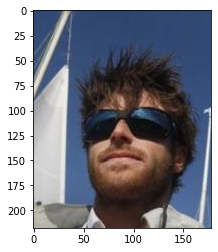

In [2]:
image = cv2.imread(image_list[3])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [3]:
image.shape

(218, 178, 3)

### Create Dataset

The data transformation pipeline resizes and crops the image to a square 64x64 pixels, finally it normalizes the values between -1 and 1 

In [4]:
imsize = 64
n_channels = 3
latent_size = 100

transform = transforms.Compose(
    [transforms.Resize(imsize),
     transforms.CenterCrop(imsize),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize between [-1 1]


dataset = torchvision.datasets.ImageFolder(root="data/",
                           transform=transform)

batch_size = 32

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2,
                                         pin_memory=True)


## GAN MODEL

### Train Model

In [5]:
from models.GAN.GAN import GAN 

save_dir = "models/GAN/model_states/"


model = GAN(device=device, save_dir=save_dir)
model.compile()



In [6]:
n_epochs = 1
model.train(dataloader, n_epochs)

[0/1][0/6332]	Loss_D: 1.3876	Loss_G: 2.2156	Acc_dis: 0.4486	Acc_gen: 0.4402 / 0.1106
[0/1][100/6332]	Loss_D: 0.1625	Loss_G: 3.7794	Acc_dis: 0.8982	Acc_gen: 0.0432 / 0.0229
[0/1][200/6332]	Loss_D: 0.0750	Loss_G: 4.2676	Acc_dis: 0.9445	Acc_gen: 0.0159 / 0.0140
[0/1][300/6332]	Loss_D: 0.4204	Loss_G: 2.0564	Acc_dis: 0.7978	Acc_gen: 0.1556 / 0.1285
[0/1][400/6332]	Loss_D: 0.0625	Loss_G: 4.6629	Acc_dis: 0.9868	Acc_gen: 0.0478 / 0.0097
[0/1][500/6332]	Loss_D: 0.0223	Loss_G: 5.7772	Acc_dis: 0.9908	Acc_gen: 0.0130 / 0.0038
[0/1][600/6332]	Loss_D: 0.0226	Loss_G: 5.8681	Acc_dis: 0.9820	Acc_gen: 0.0043 / 0.0040
[0/1][700/6332]	Loss_D: 0.2505	Loss_G: 3.7273	Acc_dis: 0.8608	Acc_gen: 0.0714 / 0.0247
[0/1][800/6332]	Loss_D: 0.9279	Loss_G: 2.1669	Acc_dis: 0.6793	Acc_gen: 0.3613 / 0.1240
[0/1][900/6332]	Loss_D: 1.0124	Loss_G: 2.5539	Acc_dis: 0.4621	Acc_gen: 0.0556 / 0.0916
[0/1][1000/6332]	Loss_D: 0.2388	Loss_G: 3.4515	Acc_dis: 0.9315	Acc_gen: 0.1427 / 0.0406
[0/1][1100/6332]	Loss_D: 0.9824	Loss_G: 5.13

### Analysis

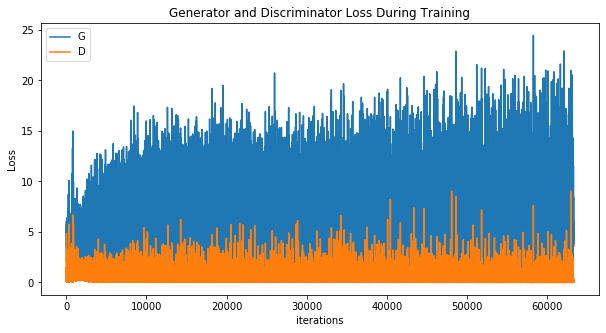

In [10]:
model.plot()

In [6]:
# load model from file 
load_dir = "models/GAN/model_states/version_0_10e/"
model.load(load_dir)

In [7]:
noise = torch.randn(32, 100,1, 1, device=device)
img = model(noise)

In [10]:
def display_images(img):
    fig = plt.figure(figsize=(16,16))
    plt.axis("off")
    img_list = [vutils.make_grid(img, padding=2, normalize=True).cpu().detach()]

    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    plt.show()

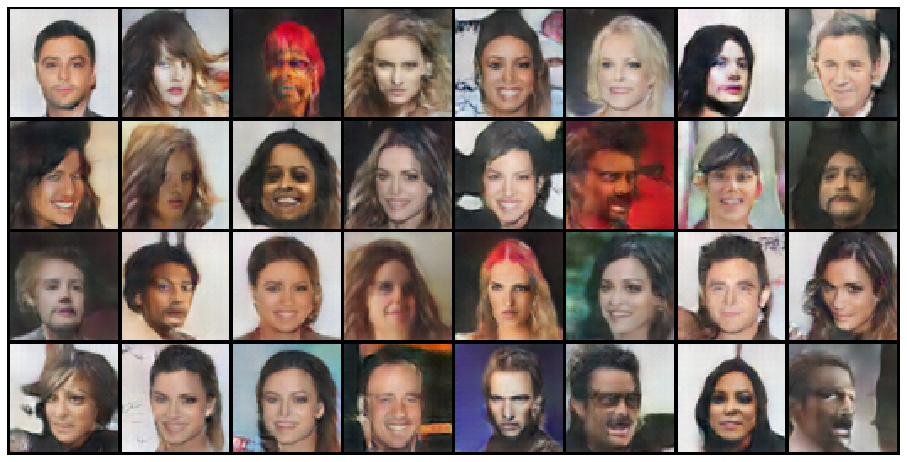

In [11]:
display_images(img)

## WGAN MODEL
### Train Model

In [5]:
from models.WGAN.WGAN import WGAN 

save_dir = "models/WGAN/model_states/"


model = WGAN(device=device, save_dir=save_dir)
model.compile()

In [6]:
g_epochs = 215000
d_epochs = 5

model.train(dataloader, g_epochs, d_epochs)

[0/215000]	Loss_D: -0.0217	Loss_G: 0.0113	Loss_D_fake: -0.0095	Loss_D_real: -0.0122	
[100/215000]	Loss_D: -0.3885	Loss_G: 0.1939	Loss_D_fake: -0.1941	Loss_D_real: -0.1943	
[200/215000]	Loss_D: -0.3940	Loss_G: 0.1966	Loss_D_fake: -0.1963	Loss_D_real: -0.1977	
[300/215000]	Loss_D: -0.0692	Loss_G: 0.1905	Loss_D_fake: 0.0287	Loss_D_real: -0.0980	
[400/215000]	Loss_D: -0.3811	Loss_G: 0.1927	Loss_D_fake: -0.1921	Loss_D_real: -0.1889	
[500/215000]	Loss_D: -0.3891	Loss_G: 0.1941	Loss_D_fake: -0.1944	Loss_D_real: -0.1947	
[600/215000]	Loss_D: -0.3907	Loss_G: 0.1957	Loss_D_fake: -0.1956	Loss_D_real: -0.1951	
[700/215000]	Loss_D: -0.3927	Loss_G: 0.1961	Loss_D_fake: -0.1956	Loss_D_real: -0.1971	
[800/215000]	Loss_D: -0.3896	Loss_G: 0.1953	Loss_D_fake: -0.1951	Loss_D_real: -0.1945	
[900/215000]	Loss_D: -0.3914	Loss_G: 0.1956	Loss_D_fake: -0.1950	Loss_D_real: -0.1964	
[1000/215000]	Loss_D: -0.3927	Loss_G: 0.1961	Loss_D_fake: -0.1959	Loss_D_real: -0.1968	
[1100/215000]	Loss_D: -0.3922	Loss_G: 0.1964	

[9400/215000]	Loss_D: -0.3897	Loss_G: 0.1946	Loss_D_fake: -0.1950	Loss_D_real: -0.1947	
[9500/215000]	Loss_D: -0.3919	Loss_G: 0.1957	Loss_D_fake: -0.1952	Loss_D_real: -0.1967	
[9600/215000]	Loss_D: -0.3929	Loss_G: 0.1960	Loss_D_fake: -0.1962	Loss_D_real: -0.1967	
[9700/215000]	Loss_D: -0.3913	Loss_G: 0.1938	Loss_D_fake: -0.1942	Loss_D_real: -0.1970	
[9800/215000]	Loss_D: -0.3925	Loss_G: 0.1959	Loss_D_fake: -0.1957	Loss_D_real: -0.1968	
[9900/215000]	Loss_D: -0.3885	Loss_G: 0.1934	Loss_D_fake: -0.1942	Loss_D_real: -0.1943	
[10000/215000]	Loss_D: -0.3921	Loss_G: 0.1958	Loss_D_fake: -0.1956	Loss_D_real: -0.1966	
[10100/215000]	Loss_D: -0.3936	Loss_G: 0.1964	Loss_D_fake: -0.1961	Loss_D_real: -0.1975	
[10200/215000]	Loss_D: -0.3939	Loss_G: 0.1966	Loss_D_fake: -0.1963	Loss_D_real: -0.1975	
[10300/215000]	Loss_D: -0.3903	Loss_G: 0.1951	Loss_D_fake: -0.1950	Loss_D_real: -0.1953	
[10400/215000]	Loss_D: -0.3906	Loss_G: 0.1945	Loss_D_fake: -0.1951	Loss_D_real: -0.1955	
[10500/215000]	Loss_D: -0.3

[18700/215000]	Loss_D: -0.3856	Loss_G: 0.1918	Loss_D_fake: -0.1930	Loss_D_real: -0.1925	
[18800/215000]	Loss_D: -0.3900	Loss_G: 0.1914	Loss_D_fake: -0.1957	Loss_D_real: -0.1943	
[18900/215000]	Loss_D: -0.3897	Loss_G: 0.1937	Loss_D_fake: -0.1942	Loss_D_real: -0.1955	
[19000/215000]	Loss_D: -0.3783	Loss_G: 0.1872	Loss_D_fake: -0.1891	Loss_D_real: -0.1893	
[19100/215000]	Loss_D: -0.3910	Loss_G: 0.1946	Loss_D_fake: -0.1949	Loss_D_real: -0.1961	
[19200/215000]	Loss_D: -0.3891	Loss_G: 0.1948	Loss_D_fake: -0.1947	Loss_D_real: -0.1945	
[19300/215000]	Loss_D: -0.3909	Loss_G: 0.1952	Loss_D_fake: -0.1947	Loss_D_real: -0.1962	
[19400/215000]	Loss_D: -0.3909	Loss_G: 0.1943	Loss_D_fake: -0.1951	Loss_D_real: -0.1958	
[19500/215000]	Loss_D: -0.3925	Loss_G: 0.1959	Loss_D_fake: -0.1956	Loss_D_real: -0.1969	
[19600/215000]	Loss_D: -0.3736	Loss_G: 0.1747	Loss_D_fake: -0.1920	Loss_D_real: -0.1816	
[19700/215000]	Loss_D: -0.3922	Loss_G: 0.1957	Loss_D_fake: -0.1957	Loss_D_real: -0.1965	
[19800/215000]	Loss_D

[28000/215000]	Loss_D: -0.3736	Loss_G: 0.1905	Loss_D_fake: -0.1823	Loss_D_real: -0.1914	
[28100/215000]	Loss_D: -0.3890	Loss_G: 0.1937	Loss_D_fake: -0.1945	Loss_D_real: -0.1944	
[28200/215000]	Loss_D: -0.3859	Loss_G: 0.1929	Loss_D_fake: -0.1931	Loss_D_real: -0.1928	
[28300/215000]	Loss_D: -0.3899	Loss_G: 0.1948	Loss_D_fake: -0.1944	Loss_D_real: -0.1955	
[28400/215000]	Loss_D: -0.3874	Loss_G: 0.1944	Loss_D_fake: -0.1933	Loss_D_real: -0.1941	
[28500/215000]	Loss_D: -0.3847	Loss_G: 0.1936	Loss_D_fake: -0.1915	Loss_D_real: -0.1932	
[28600/215000]	Loss_D: -0.3875	Loss_G: 0.1932	Loss_D_fake: -0.1930	Loss_D_real: -0.1945	
[28700/215000]	Loss_D: -0.3868	Loss_G: 0.1943	Loss_D_fake: -0.1917	Loss_D_real: -0.1951	
[28800/215000]	Loss_D: -0.2124	Loss_G: 0.1832	Loss_D_fake: -0.0316	Loss_D_real: -0.1807	
[28900/215000]	Loss_D: -0.3885	Loss_G: 0.1942	Loss_D_fake: -0.1935	Loss_D_real: -0.1950	
[29000/215000]	Loss_D: -0.3861	Loss_G: 0.1913	Loss_D_fake: -0.1939	Loss_D_real: -0.1922	
[29100/215000]	Loss_D

[37300/215000]	Loss_D: -0.3885	Loss_G: 0.1938	Loss_D_fake: -0.1935	Loss_D_real: -0.1950	
[37400/215000]	Loss_D: -0.3813	Loss_G: 0.1898	Loss_D_fake: -0.1913	Loss_D_real: -0.1899	
[37500/215000]	Loss_D: -0.3876	Loss_G: 0.1920	Loss_D_fake: -0.1932	Loss_D_real: -0.1945	
[37600/215000]	Loss_D: -0.3809	Loss_G: 0.1882	Loss_D_fake: -0.1907	Loss_D_real: -0.1902	
[37700/215000]	Loss_D: -0.3895	Loss_G: 0.1937	Loss_D_fake: -0.1942	Loss_D_real: -0.1953	
[37800/215000]	Loss_D: -0.1876	Loss_G: 0.0105	Loss_D_fake: -0.1798	Loss_D_real: -0.0078	
[37900/215000]	Loss_D: -0.3859	Loss_G: 0.1918	Loss_D_fake: -0.1927	Loss_D_real: -0.1932	
[38000/215000]	Loss_D: -0.3877	Loss_G: 0.1935	Loss_D_fake: -0.1935	Loss_D_real: -0.1942	
[38100/215000]	Loss_D: -0.3849	Loss_G: 0.1917	Loss_D_fake: -0.1937	Loss_D_real: -0.1912	
[38200/215000]	Loss_D: -0.3332	Loss_G: 0.1703	Loss_D_fake: -0.1751	Loss_D_real: -0.1580	
[38300/215000]	Loss_D: -0.0162	Loss_G: 0.1834	Loss_D_fake: -0.1877	Loss_D_real: 0.1715	
[38400/215000]	Loss_D:

[46600/215000]	Loss_D: -0.3818	Loss_G: 0.1876	Loss_D_fake: -0.1914	Loss_D_real: -0.1904	
[46700/215000]	Loss_D: -0.3792	Loss_G: 0.1912	Loss_D_fake: -0.1887	Loss_D_real: -0.1905	
[46800/215000]	Loss_D: -0.3873	Loss_G: 0.1937	Loss_D_fake: -0.1933	Loss_D_real: -0.1940	
[46900/215000]	Loss_D: -0.3828	Loss_G: 0.1908	Loss_D_fake: -0.1921	Loss_D_real: -0.1906	
[47000/215000]	Loss_D: -0.3638	Loss_G: 0.1898	Loss_D_fake: -0.1845	Loss_D_real: -0.1793	
[47100/215000]	Loss_D: -0.3736	Loss_G: 0.1902	Loss_D_fake: -0.1875	Loss_D_real: -0.1862	
[47200/215000]	Loss_D: -0.3852	Loss_G: 0.1909	Loss_D_fake: -0.1913	Loss_D_real: -0.1939	
[47300/215000]	Loss_D: -0.3787	Loss_G: 0.1921	Loss_D_fake: -0.1871	Loss_D_real: -0.1916	
[47400/215000]	Loss_D: -0.3788	Loss_G: 0.1906	Loss_D_fake: -0.1919	Loss_D_real: -0.1870	
[47500/215000]	Loss_D: -0.3843	Loss_G: 0.1914	Loss_D_fake: -0.1913	Loss_D_real: -0.1930	
[47600/215000]	Loss_D: -0.3834	Loss_G: 0.1912	Loss_D_fake: -0.1914	Loss_D_real: -0.1920	
[47700/215000]	Loss_D

[55900/215000]	Loss_D: -0.3683	Loss_G: 0.1861	Loss_D_fake: -0.1865	Loss_D_real: -0.1819	
[56000/215000]	Loss_D: -0.3785	Loss_G: 0.1914	Loss_D_fake: -0.1864	Loss_D_real: -0.1920	
[56100/215000]	Loss_D: -0.3793	Loss_G: 0.1852	Loss_D_fake: -0.1915	Loss_D_real: -0.1879	
[56200/215000]	Loss_D: -0.3747	Loss_G: 0.1878	Loss_D_fake: -0.1883	Loss_D_real: -0.1864	
[56300/215000]	Loss_D: -0.3697	Loss_G: 0.1871	Loss_D_fake: -0.1861	Loss_D_real: -0.1836	
[56400/215000]	Loss_D: -0.3702	Loss_G: 0.1827	Loss_D_fake: -0.1900	Loss_D_real: -0.1802	
[56500/215000]	Loss_D: -0.2771	Loss_G: 0.1894	Loss_D_fake: -0.0884	Loss_D_real: -0.1887	
[56600/215000]	Loss_D: -0.3577	Loss_G: 0.1876	Loss_D_fake: -0.1701	Loss_D_real: -0.1876	
[56700/215000]	Loss_D: -0.2554	Loss_G: 0.1780	Loss_D_fake: -0.0857	Loss_D_real: -0.1697	
[56800/215000]	Loss_D: -0.1804	Loss_G: -0.0217	Loss_D_fake: -0.1773	Loss_D_real: -0.0030	
[56900/215000]	Loss_D: -0.3809	Loss_G: 0.1894	Loss_D_fake: -0.1915	Loss_D_real: -0.1895	
[57000/215000]	Loss_

[65200/215000]	Loss_D: -0.3816	Loss_G: 0.1904	Loss_D_fake: -0.1913	Loss_D_real: -0.1903	
[65300/215000]	Loss_D: -0.3388	Loss_G: 0.1728	Loss_D_fake: -0.1813	Loss_D_real: -0.1575	
[65400/215000]	Loss_D: -0.3807	Loss_G: 0.1867	Loss_D_fake: -0.1909	Loss_D_real: -0.1899	
[65500/215000]	Loss_D: -0.3791	Loss_G: 0.1898	Loss_D_fake: -0.1894	Loss_D_real: -0.1897	
[65600/215000]	Loss_D: -0.3774	Loss_G: 0.1828	Loss_D_fake: -0.1926	Loss_D_real: -0.1848	
[65700/215000]	Loss_D: -0.3833	Loss_G: 0.1909	Loss_D_fake: -0.1913	Loss_D_real: -0.1920	
[65800/215000]	Loss_D: -0.3786	Loss_G: 0.1892	Loss_D_fake: -0.1878	Loss_D_real: -0.1908	
[65900/215000]	Loss_D: -0.2971	Loss_G: 0.1406	Loss_D_fake: -0.1626	Loss_D_real: -0.1345	
[66000/215000]	Loss_D: -0.3778	Loss_G: 0.1875	Loss_D_fake: -0.1897	Loss_D_real: -0.1881	
[66100/215000]	Loss_D: -0.3770	Loss_G: 0.1889	Loss_D_fake: -0.1888	Loss_D_real: -0.1882	
[66200/215000]	Loss_D: -0.3790	Loss_G: 0.1887	Loss_D_fake: -0.1888	Loss_D_real: -0.1902	
[66300/215000]	Loss_D

[74500/215000]	Loss_D: -0.3543	Loss_G: 0.1755	Loss_D_fake: -0.1770	Loss_D_real: -0.1773	
[74600/215000]	Loss_D: -0.3174	Loss_G: 0.1421	Loss_D_fake: -0.1736	Loss_D_real: -0.1438	
[74700/215000]	Loss_D: -0.3645	Loss_G: 0.1872	Loss_D_fake: -0.1761	Loss_D_real: -0.1884	
[74800/215000]	Loss_D: -0.3769	Loss_G: 0.1863	Loss_D_fake: -0.1905	Loss_D_real: -0.1864	
[74900/215000]	Loss_D: -0.3753	Loss_G: 0.1832	Loss_D_fake: -0.1860	Loss_D_real: -0.1894	
[75000/215000]	Loss_D: -0.3576	Loss_G: 0.1809	Loss_D_fake: -0.1799	Loss_D_real: -0.1777	
[75100/215000]	Loss_D: -0.3766	Loss_G: 0.1873	Loss_D_fake: -0.1897	Loss_D_real: -0.1869	
[75200/215000]	Loss_D: -0.3790	Loss_G: 0.1892	Loss_D_fake: -0.1884	Loss_D_real: -0.1906	
[75300/215000]	Loss_D: -0.3751	Loss_G: 0.1880	Loss_D_fake: -0.1868	Loss_D_real: -0.1882	
[75400/215000]	Loss_D: -0.3692	Loss_G: 0.1794	Loss_D_fake: -0.1871	Loss_D_real: -0.1821	
[75500/215000]	Loss_D: -0.3728	Loss_G: 0.1833	Loss_D_fake: -0.1903	Loss_D_real: -0.1825	
[75600/215000]	Loss_D

[83800/215000]	Loss_D: -0.3719	Loss_G: 0.1838	Loss_D_fake: -0.1873	Loss_D_real: -0.1846	
[83900/215000]	Loss_D: -0.3763	Loss_G: 0.1906	Loss_D_fake: -0.1892	Loss_D_real: -0.1871	
[84000/215000]	Loss_D: -0.3789	Loss_G: 0.1874	Loss_D_fake: -0.1885	Loss_D_real: -0.1904	
[84100/215000]	Loss_D: -0.3704	Loss_G: 0.1782	Loss_D_fake: -0.1843	Loss_D_real: -0.1860	
[84200/215000]	Loss_D: -0.3051	Loss_G: 0.1748	Loss_D_fake: -0.1299	Loss_D_real: -0.1752	
[84300/215000]	Loss_D: -0.3738	Loss_G: 0.1865	Loss_D_fake: -0.1854	Loss_D_real: -0.1884	
[84400/215000]	Loss_D: -0.3765	Loss_G: 0.1881	Loss_D_fake: -0.1872	Loss_D_real: -0.1892	
[84500/215000]	Loss_D: -0.1285	Loss_G: 0.1659	Loss_D_fake: 0.0591	Loss_D_real: -0.1876	
[84600/215000]	Loss_D: -0.3747	Loss_G: 0.1893	Loss_D_fake: -0.1843	Loss_D_real: -0.1904	
[84700/215000]	Loss_D: -0.3307	Loss_G: 0.1826	Loss_D_fake: -0.1568	Loss_D_real: -0.1738	
[84800/215000]	Loss_D: -0.1699	Loss_G: 0.0281	Loss_D_fake: -0.1748	Loss_D_real: 0.0049	
[84900/215000]	Loss_D: 

[93100/215000]	Loss_D: -0.3743	Loss_G: 0.1898	Loss_D_fake: -0.1851	Loss_D_real: -0.1892	
[93200/215000]	Loss_D: -0.3791	Loss_G: 0.1898	Loss_D_fake: -0.1864	Loss_D_real: -0.1928	
[93300/215000]	Loss_D: -0.3582	Loss_G: 0.1775	Loss_D_fake: -0.1834	Loss_D_real: -0.1748	
[93400/215000]	Loss_D: -0.3742	Loss_G: 0.1855	Loss_D_fake: -0.1857	Loss_D_real: -0.1885	
[93500/215000]	Loss_D: -0.3362	Loss_G: 0.1834	Loss_D_fake: -0.1526	Loss_D_real: -0.1836	
[93600/215000]	Loss_D: -0.3722	Loss_G: 0.1896	Loss_D_fake: -0.1847	Loss_D_real: -0.1875	
[93700/215000]	Loss_D: -0.3775	Loss_G: 0.1881	Loss_D_fake: -0.1917	Loss_D_real: -0.1858	
[93800/215000]	Loss_D: -0.1415	Loss_G: 0.1812	Loss_D_fake: 0.0268	Loss_D_real: -0.1683	
[93900/215000]	Loss_D: -0.3733	Loss_G: 0.1883	Loss_D_fake: -0.1875	Loss_D_real: -0.1858	
[94000/215000]	Loss_D: -0.3713	Loss_G: 0.1821	Loss_D_fake: -0.1882	Loss_D_real: -0.1831	
[94100/215000]	Loss_D: -0.3740	Loss_G: 0.1871	Loss_D_fake: -0.1870	Loss_D_real: -0.1870	
[94200/215000]	Loss_D:

[102300/215000]	Loss_D: -0.3351	Loss_G: 0.1715	Loss_D_fake: -0.1833	Loss_D_real: -0.1518	
[102400/215000]	Loss_D: -0.3799	Loss_G: 0.1900	Loss_D_fake: -0.1893	Loss_D_real: -0.1906	
[102500/215000]	Loss_D: -0.3805	Loss_G: 0.1900	Loss_D_fake: -0.1899	Loss_D_real: -0.1905	
[102600/215000]	Loss_D: -0.3362	Loss_G: 0.1730	Loss_D_fake: -0.1835	Loss_D_real: -0.1527	
[102700/215000]	Loss_D: -0.3792	Loss_G: 0.1914	Loss_D_fake: -0.1916	Loss_D_real: -0.1875	
[102800/215000]	Loss_D: -0.3819	Loss_G: 0.1901	Loss_D_fake: -0.1907	Loss_D_real: -0.1913	
[102900/215000]	Loss_D: -0.3725	Loss_G: 0.1872	Loss_D_fake: -0.1843	Loss_D_real: -0.1882	
[103000/215000]	Loss_D: -0.3763	Loss_G: 0.1842	Loss_D_fake: -0.1920	Loss_D_real: -0.1842	
[103100/215000]	Loss_D: -0.3797	Loss_G: 0.1898	Loss_D_fake: -0.1912	Loss_D_real: -0.1885	
[103200/215000]	Loss_D: -0.3605	Loss_G: 0.1799	Loss_D_fake: -0.1840	Loss_D_real: -0.1765	
[103300/215000]	Loss_D: -0.3825	Loss_G: 0.1900	Loss_D_fake: -0.1901	Loss_D_real: -0.1924	
[103400/21

[111500/215000]	Loss_D: -0.3821	Loss_G: 0.1922	Loss_D_fake: -0.1906	Loss_D_real: -0.1915	
[111600/215000]	Loss_D: -0.3839	Loss_G: 0.1913	Loss_D_fake: -0.1913	Loss_D_real: -0.1926	
[111700/215000]	Loss_D: -0.3706	Loss_G: 0.1874	Loss_D_fake: -0.1861	Loss_D_real: -0.1846	
[111800/215000]	Loss_D: -0.1894	Loss_G: -0.0306	Loss_D_fake: -0.1693	Loss_D_real: -0.0201	
[111900/215000]	Loss_D: -0.3821	Loss_G: 0.1914	Loss_D_fake: -0.1912	Loss_D_real: -0.1909	
[112000/215000]	Loss_D: -0.3797	Loss_G: 0.1906	Loss_D_fake: -0.1897	Loss_D_real: -0.1900	
[112100/215000]	Loss_D: -0.3716	Loss_G: 0.1878	Loss_D_fake: -0.1876	Loss_D_real: -0.1840	
[112200/215000]	Loss_D: -0.3828	Loss_G: 0.1916	Loss_D_fake: -0.1903	Loss_D_real: -0.1925	
[112300/215000]	Loss_D: -0.3823	Loss_G: 0.1892	Loss_D_fake: -0.1919	Loss_D_real: -0.1904	
[112400/215000]	Loss_D: -0.3863	Loss_G: 0.1914	Loss_D_fake: -0.1937	Loss_D_real: -0.1926	
[112500/215000]	Loss_D: -0.3849	Loss_G: 0.1920	Loss_D_fake: -0.1922	Loss_D_real: -0.1927	
[112600/2

[120700/215000]	Loss_D: -0.3860	Loss_G: 0.1911	Loss_D_fake: -0.1924	Loss_D_real: -0.1936	
[120800/215000]	Loss_D: -0.3818	Loss_G: 0.1900	Loss_D_fake: -0.1927	Loss_D_real: -0.1891	
[120900/215000]	Loss_D: -0.3846	Loss_G: 0.1925	Loss_D_fake: -0.1909	Loss_D_real: -0.1936	
[121000/215000]	Loss_D: -0.3856	Loss_G: 0.1922	Loss_D_fake: -0.1924	Loss_D_real: -0.1932	
[121100/215000]	Loss_D: -0.3796	Loss_G: 0.1896	Loss_D_fake: -0.1911	Loss_D_real: -0.1884	
[121200/215000]	Loss_D: -0.1327	Loss_G: 0.0891	Loss_D_fake: -0.1873	Loss_D_real: 0.0546	
[121300/215000]	Loss_D: -0.3805	Loss_G: 0.1912	Loss_D_fake: -0.1918	Loss_D_real: -0.1887	
[121400/215000]	Loss_D: -0.3813	Loss_G: 0.1893	Loss_D_fake: -0.1926	Loss_D_real: -0.1886	
[121500/215000]	Loss_D: -0.3844	Loss_G: 0.1878	Loss_D_fake: -0.1927	Loss_D_real: -0.1917	
[121600/215000]	Loss_D: -0.3811	Loss_G: 0.1915	Loss_D_fake: -0.1883	Loss_D_real: -0.1928	
[121700/215000]	Loss_D: -0.3863	Loss_G: 0.1923	Loss_D_fake: -0.1929	Loss_D_real: -0.1934	
[121800/215

[129900/215000]	Loss_D: -0.3827	Loss_G: 0.1917	Loss_D_fake: -0.1923	Loss_D_real: -0.1904	
[130000/215000]	Loss_D: -0.3606	Loss_G: 0.1754	Loss_D_fake: -0.1786	Loss_D_real: -0.1820	
[130100/215000]	Loss_D: -0.3716	Loss_G: 0.1855	Loss_D_fake: -0.1871	Loss_D_real: -0.1845	
[130200/215000]	Loss_D: -0.3781	Loss_G: 0.1878	Loss_D_fake: -0.1899	Loss_D_real: -0.1882	
[130300/215000]	Loss_D: -0.3778	Loss_G: 0.1894	Loss_D_fake: -0.1886	Loss_D_real: -0.1892	
[130400/215000]	Loss_D: -0.3857	Loss_G: 0.1926	Loss_D_fake: -0.1912	Loss_D_real: -0.1945	
[130500/215000]	Loss_D: -0.3801	Loss_G: 0.1894	Loss_D_fake: -0.1914	Loss_D_real: -0.1887	
[130600/215000]	Loss_D: -0.3846	Loss_G: 0.1923	Loss_D_fake: -0.1907	Loss_D_real: -0.1939	
[130700/215000]	Loss_D: -0.3852	Loss_G: 0.1927	Loss_D_fake: -0.1914	Loss_D_real: -0.1939	
[130800/215000]	Loss_D: -0.3841	Loss_G: 0.1916	Loss_D_fake: -0.1916	Loss_D_real: -0.1925	
[130900/215000]	Loss_D: -0.3391	Loss_G: 0.1890	Loss_D_fake: -0.1448	Loss_D_real: -0.1944	
[131000/21

[139100/215000]	Loss_D: -0.3851	Loss_G: 0.1931	Loss_D_fake: -0.1927	Loss_D_real: -0.1925	
[139200/215000]	Loss_D: -0.3850	Loss_G: 0.1913	Loss_D_fake: -0.1923	Loss_D_real: -0.1927	
[139300/215000]	Loss_D: -0.2086	Loss_G: 0.1838	Loss_D_fake: -0.0253	Loss_D_real: -0.1834	
[139400/215000]	Loss_D: -0.2840	Loss_G: 0.1800	Loss_D_fake: -0.0982	Loss_D_real: -0.1858	
[139500/215000]	Loss_D: -0.3846	Loss_G: 0.1874	Loss_D_fake: -0.1933	Loss_D_real: -0.1913	
[139600/215000]	Loss_D: -0.1461	Loss_G: 0.1778	Loss_D_fake: 0.0290	Loss_D_real: -0.1751	
[139700/215000]	Loss_D: -0.3861	Loss_G: 0.1916	Loss_D_fake: -0.1932	Loss_D_real: -0.1929	
[139800/215000]	Loss_D: -0.3817	Loss_G: 0.1901	Loss_D_fake: -0.1890	Loss_D_real: -0.1927	
[139900/215000]	Loss_D: -0.3858	Loss_G: 0.1913	Loss_D_fake: -0.1917	Loss_D_real: -0.1940	
[140000/215000]	Loss_D: -0.3832	Loss_G: 0.1901	Loss_D_fake: -0.1890	Loss_D_real: -0.1942	
[140100/215000]	Loss_D: -0.3852	Loss_G: 0.1913	Loss_D_fake: -0.1918	Loss_D_real: -0.1934	
[140200/215

[148300/215000]	Loss_D: -0.3860	Loss_G: 0.1932	Loss_D_fake: -0.1923	Loss_D_real: -0.1937	
[148400/215000]	Loss_D: -0.3726	Loss_G: 0.1898	Loss_D_fake: -0.1843	Loss_D_real: -0.1884	
[148500/215000]	Loss_D: -0.3774	Loss_G: 0.1840	Loss_D_fake: -0.1918	Loss_D_real: -0.1856	
[148600/215000]	Loss_D: -0.3771	Loss_G: 0.1882	Loss_D_fake: -0.1871	Loss_D_real: -0.1900	
[148700/215000]	Loss_D: -0.3801	Loss_G: 0.1908	Loss_D_fake: -0.1929	Loss_D_real: -0.1872	
[148800/215000]	Loss_D: -0.3845	Loss_G: 0.1918	Loss_D_fake: -0.1901	Loss_D_real: -0.1943	
[148900/215000]	Loss_D: -0.3667	Loss_G: 0.1860	Loss_D_fake: -0.1842	Loss_D_real: -0.1825	
[149000/215000]	Loss_D: -0.3749	Loss_G: 0.1879	Loss_D_fake: -0.1850	Loss_D_real: -0.1899	
[149100/215000]	Loss_D: -0.3834	Loss_G: 0.1903	Loss_D_fake: -0.1900	Loss_D_real: -0.1934	
[149200/215000]	Loss_D: -0.3811	Loss_G: 0.1910	Loss_D_fake: -0.1896	Loss_D_real: -0.1916	
[149300/215000]	Loss_D: -0.3859	Loss_G: 0.1922	Loss_D_fake: -0.1909	Loss_D_real: -0.1950	
[149400/21

[157500/215000]	Loss_D: -0.3705	Loss_G: 0.1860	Loss_D_fake: -0.1821	Loss_D_real: -0.1885	
[157600/215000]	Loss_D: -0.3845	Loss_G: 0.1926	Loss_D_fake: -0.1914	Loss_D_real: -0.1930	
[157700/215000]	Loss_D: -0.3818	Loss_G: 0.1877	Loss_D_fake: -0.1913	Loss_D_real: -0.1905	
[157800/215000]	Loss_D: -0.3823	Loss_G: 0.1902	Loss_D_fake: -0.1924	Loss_D_real: -0.1899	
[157900/215000]	Loss_D: -0.3803	Loss_G: 0.1905	Loss_D_fake: -0.1902	Loss_D_real: -0.1900	
[158000/215000]	Loss_D: -0.3830	Loss_G: 0.1891	Loss_D_fake: -0.1912	Loss_D_real: -0.1918	
[158100/215000]	Loss_D: -0.3630	Loss_G: 0.1814	Loss_D_fake: -0.1799	Loss_D_real: -0.1830	
[158200/215000]	Loss_D: -0.3775	Loss_G: 0.1906	Loss_D_fake: -0.1863	Loss_D_real: -0.1912	
[158300/215000]	Loss_D: -0.3763	Loss_G: 0.1902	Loss_D_fake: -0.1862	Loss_D_real: -0.1901	
[158400/215000]	Loss_D: -0.3819	Loss_G: 0.1908	Loss_D_fake: -0.1905	Loss_D_real: -0.1915	
[158500/215000]	Loss_D: -0.3761	Loss_G: 0.1911	Loss_D_fake: -0.1834	Loss_D_real: -0.1927	
[158600/21

[166700/215000]	Loss_D: -0.3806	Loss_G: 0.1864	Loss_D_fake: -0.1905	Loss_D_real: -0.1901	
[166800/215000]	Loss_D: -0.3796	Loss_G: 0.1905	Loss_D_fake: -0.1890	Loss_D_real: -0.1907	
[166900/215000]	Loss_D: -0.3801	Loss_G: 0.1889	Loss_D_fake: -0.1894	Loss_D_real: -0.1907	
[167000/215000]	Loss_D: -0.3794	Loss_G: 0.1907	Loss_D_fake: -0.1886	Loss_D_real: -0.1907	
[167100/215000]	Loss_D: -0.3794	Loss_G: 0.1878	Loss_D_fake: -0.1889	Loss_D_real: -0.1905	
[167200/215000]	Loss_D: -0.3842	Loss_G: 0.1916	Loss_D_fake: -0.1920	Loss_D_real: -0.1922	
[167300/215000]	Loss_D: -0.3835	Loss_G: 0.1922	Loss_D_fake: -0.1898	Loss_D_real: -0.1938	
[167400/215000]	Loss_D: -0.3853	Loss_G: 0.1899	Loss_D_fake: -0.1918	Loss_D_real: -0.1934	
[167500/215000]	Loss_D: -0.3842	Loss_G: 0.1918	Loss_D_fake: -0.1917	Loss_D_real: -0.1925	
[167600/215000]	Loss_D: -0.3817	Loss_G: 0.1908	Loss_D_fake: -0.1921	Loss_D_real: -0.1896	
[167700/215000]	Loss_D: -0.3850	Loss_G: 0.1920	Loss_D_fake: -0.1923	Loss_D_real: -0.1927	
[167800/21

[175900/215000]	Loss_D: -0.3797	Loss_G: 0.1898	Loss_D_fake: -0.1882	Loss_D_real: -0.1915	
[176000/215000]	Loss_D: -0.2166	Loss_G: 0.1294	Loss_D_fake: -0.1797	Loss_D_real: -0.0369	
[176100/215000]	Loss_D: -0.3833	Loss_G: 0.1926	Loss_D_fake: -0.1891	Loss_D_real: -0.1943	
[176200/215000]	Loss_D: -0.3844	Loss_G: 0.1892	Loss_D_fake: -0.1920	Loss_D_real: -0.1925	
[176300/215000]	Loss_D: -0.3823	Loss_G: 0.1884	Loss_D_fake: -0.1920	Loss_D_real: -0.1903	
[176400/215000]	Loss_D: -0.3790	Loss_G: 0.1896	Loss_D_fake: -0.1914	Loss_D_real: -0.1877	
[176500/215000]	Loss_D: -0.3815	Loss_G: 0.1903	Loss_D_fake: -0.1916	Loss_D_real: -0.1900	
[176600/215000]	Loss_D: -0.3821	Loss_G: 0.1920	Loss_D_fake: -0.1904	Loss_D_real: -0.1917	
[176700/215000]	Loss_D: -0.3781	Loss_G: 0.1876	Loss_D_fake: -0.1886	Loss_D_real: -0.1895	
[176800/215000]	Loss_D: -0.3789	Loss_G: 0.1919	Loss_D_fake: -0.1893	Loss_D_real: -0.1896	
[176900/215000]	Loss_D: -0.3802	Loss_G: 0.1901	Loss_D_fake: -0.1898	Loss_D_real: -0.1905	
[177000/21

[185100/215000]	Loss_D: -0.3838	Loss_G: 0.1904	Loss_D_fake: -0.1915	Loss_D_real: -0.1922	
[185200/215000]	Loss_D: -0.3837	Loss_G: 0.1899	Loss_D_fake: -0.1915	Loss_D_real: -0.1922	
[185300/215000]	Loss_D: -0.3814	Loss_G: 0.1890	Loss_D_fake: -0.1909	Loss_D_real: -0.1904	
[185400/215000]	Loss_D: -0.3836	Loss_G: 0.1903	Loss_D_fake: -0.1900	Loss_D_real: -0.1936	
[185500/215000]	Loss_D: -0.3808	Loss_G: 0.1902	Loss_D_fake: -0.1895	Loss_D_real: -0.1913	
[185600/215000]	Loss_D: -0.3805	Loss_G: 0.1898	Loss_D_fake: -0.1895	Loss_D_real: -0.1910	
[185700/215000]	Loss_D: -0.3850	Loss_G: 0.1900	Loss_D_fake: -0.1920	Loss_D_real: -0.1930	
[185800/215000]	Loss_D: -0.3793	Loss_G: 0.1882	Loss_D_fake: -0.1901	Loss_D_real: -0.1892	
[185900/215000]	Loss_D: -0.3804	Loss_G: 0.1899	Loss_D_fake: -0.1895	Loss_D_real: -0.1909	
[186000/215000]	Loss_D: -0.3836	Loss_G: 0.1914	Loss_D_fake: -0.1903	Loss_D_real: -0.1933	
[186100/215000]	Loss_D: -0.3325	Loss_G: 0.1681	Loss_D_fake: -0.1856	Loss_D_real: -0.1470	
[186200/21

[194300/215000]	Loss_D: -0.3821	Loss_G: 0.1915	Loss_D_fake: -0.1879	Loss_D_real: -0.1942	
[194400/215000]	Loss_D: -0.0258	Loss_G: 0.1729	Loss_D_fake: -0.1861	Loss_D_real: 0.1603	
[194500/215000]	Loss_D: -0.3767	Loss_G: 0.1881	Loss_D_fake: -0.1896	Loss_D_real: -0.1871	
[194600/215000]	Loss_D: -0.3825	Loss_G: 0.1902	Loss_D_fake: -0.1902	Loss_D_real: -0.1923	
[194700/215000]	Loss_D: -0.3814	Loss_G: 0.1879	Loss_D_fake: -0.1910	Loss_D_real: -0.1905	
[194800/215000]	Loss_D: -0.3830	Loss_G: 0.1910	Loss_D_fake: -0.1906	Loss_D_real: -0.1924	
[194900/215000]	Loss_D: -0.3775	Loss_G: 0.1863	Loss_D_fake: -0.1895	Loss_D_real: -0.1880	
[195000/215000]	Loss_D: -0.3651	Loss_G: 0.1785	Loss_D_fake: -0.1840	Loss_D_real: -0.1811	
[195100/215000]	Loss_D: -0.3817	Loss_G: 0.1898	Loss_D_fake: -0.1884	Loss_D_real: -0.1933	
[195200/215000]	Loss_D: -0.3809	Loss_G: 0.1910	Loss_D_fake: -0.1891	Loss_D_real: -0.1919	
[195300/215000]	Loss_D: -0.3801	Loss_G: 0.1894	Loss_D_fake: -0.1902	Loss_D_real: -0.1899	
[195400/215

[203500/215000]	Loss_D: -0.3764	Loss_G: 0.1905	Loss_D_fake: -0.1885	Loss_D_real: -0.1879	
[203600/215000]	Loss_D: -0.3796	Loss_G: 0.1898	Loss_D_fake: -0.1892	Loss_D_real: -0.1904	
[203700/215000]	Loss_D: -0.3805	Loss_G: 0.1862	Loss_D_fake: -0.1908	Loss_D_real: -0.1897	
[203800/215000]	Loss_D: -0.3718	Loss_G: 0.1866	Loss_D_fake: -0.1861	Loss_D_real: -0.1856	
[203900/215000]	Loss_D: -0.3654	Loss_G: 0.1751	Loss_D_fake: -0.1847	Loss_D_real: -0.1807	
[204000/215000]	Loss_D: -0.1140	Loss_G: 0.0510	Loss_D_fake: -0.1830	Loss_D_real: 0.0690	
[204100/215000]	Loss_D: -0.3797	Loss_G: 0.1898	Loss_D_fake: -0.1912	Loss_D_real: -0.1885	
[204200/215000]	Loss_D: -0.3826	Loss_G: 0.1889	Loss_D_fake: -0.1917	Loss_D_real: -0.1910	
[204300/215000]	Loss_D: -0.3812	Loss_G: 0.1896	Loss_D_fake: -0.1902	Loss_D_real: -0.1910	
[204400/215000]	Loss_D: -0.3842	Loss_G: 0.1870	Loss_D_fake: -0.1918	Loss_D_real: -0.1924	
[204500/215000]	Loss_D: -0.3559	Loss_G: 0.1813	Loss_D_fake: -0.1789	Loss_D_real: -0.1770	
[204600/215

[212700/215000]	Loss_D: -0.3092	Loss_G: 0.1816	Loss_D_fake: -0.1314	Loss_D_real: -0.1778	
[212800/215000]	Loss_D: -0.3762	Loss_G: 0.1882	Loss_D_fake: -0.1900	Loss_D_real: -0.1862	
[212900/215000]	Loss_D: -0.3834	Loss_G: 0.1887	Loss_D_fake: -0.1910	Loss_D_real: -0.1924	
[213000/215000]	Loss_D: -0.3153	Loss_G: 0.1806	Loss_D_fake: -0.1562	Loss_D_real: -0.1591	
[213100/215000]	Loss_D: -0.1336	Loss_G: -0.0137	Loss_D_fake: -0.1864	Loss_D_real: 0.0529	
[213200/215000]	Loss_D: -0.3814	Loss_G: 0.1888	Loss_D_fake: -0.1881	Loss_D_real: -0.1933	
[213300/215000]	Loss_D: -0.3782	Loss_G: 0.1913	Loss_D_fake: -0.1886	Loss_D_real: -0.1897	
[213400/215000]	Loss_D: -0.3771	Loss_G: 0.1892	Loss_D_fake: -0.1915	Loss_D_real: -0.1856	
[213500/215000]	Loss_D: -0.3814	Loss_G: 0.1892	Loss_D_fake: -0.1901	Loss_D_real: -0.1913	
[213600/215000]	Loss_D: -0.3798	Loss_G: 0.1895	Loss_D_fake: -0.1894	Loss_D_real: -0.1904	
[213700/215000]	Loss_D: -0.3786	Loss_G: 0.1862	Loss_D_fake: -0.1867	Loss_D_real: -0.1919	
[213800/21

### Model analysis

/home/pol/Documents/ml/env3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


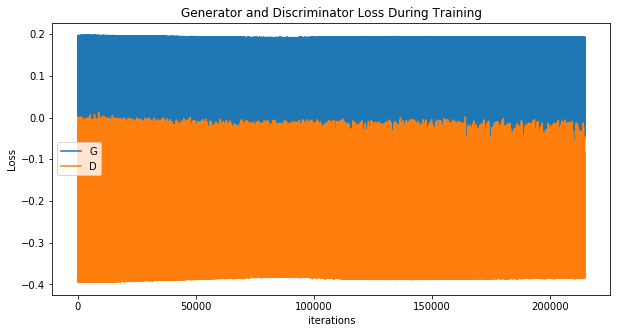

In [7]:
model.plot()

In [11]:
noise = torch.randn(32, 100,1, 1, device=device)
img = model(noise)

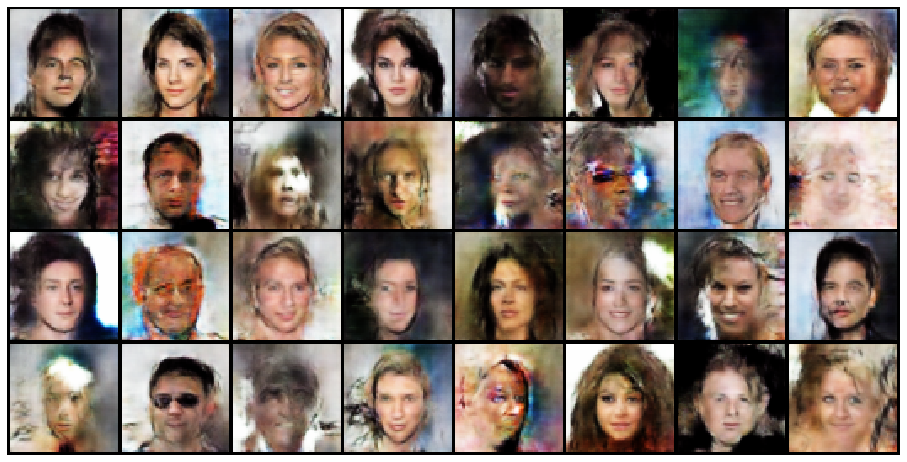

In [12]:
display_images(img)

## WGAN-GP
### Train Model

### Model analysis